<img src="https://d3i71xaburhd42.cloudfront.net/261c3e30bae8b8bdc83541ffa9331b52fcf015e6/3-Figure2-1.png" width=50% >

# <center> Assignment 1: Photometric Stereo & Colour </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59 PM, September 17, 2022 (Amsterdam time) </center>
    
***

## General guidelines
Your code and discussion must be submitted through this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 1 Assignment. For full credit, make sure your answer follows these guidelines:
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

## 0 Environment Set Up

You are allowed to use **only** the following library versions:
- python=3.10.4
- matplotlib==3.5.3
- matplotlib-inline==0.1.6
- numpy==1.23.2
- opencv-python==4.6.0.66

Using functions that are not working in these versions could lead to grade deduction.

## 1 Photometric Stereo (50pts)

In this part of the assignment, you are going to implement the photometric stereo algorithm as described in Section 5.4 (Forsyth and Ponce, *Computer Vision: A Modern Approach*). The chapter snippet can be found in the course materials.

Following this instruction, you will have to edit and fill in your code in the functions **estimate_alb_nrm**, **check_integrability**, and **construct_surface**. The main function **photometric_stereo** is provided for reference and should not be taken as is. Throughout the assignment, you will be asked to perform different trials and experiments which will require you to adjust the main code accordingly, this also shows how well you can cope with the materials.

Include images of the results into this notebook. For 3D models, make sure to choose a viewpoint that makes the structure as clear as possible and/or feel free to take them from multiple viewpoints.

### 1.1 Estimating Albedo and Surface Normal (15pts)
Let us start with the grayscale sphere model, which is located in the SphereGray5 folder. The folder contains 5 images of a sphere with grayscale checker texture under similar lighting conditions with the one in the book. Your task is to estimate the surface reflectance (albedo) and surface normal of this model. The light source directions are encoded in the image file names.

1. Complete the code for function **estimate_alb_nrm()** to estimate albedo and surface normal map for the SphereGray5 folder. What do you expect to see in albedo image and how is it different with your result?
2. In principle, what is the minimum number of images you need to estimate albedo and surface normal? Run the algorithm with more images by using SphereGray25 and observe the differences in the results. You could try all images at once or a few at the time, in an incremental fashion. Choose a strategy and justify it by discussing your results.
3. What is the impact of shadows in photometric stereo? Explain the trick that is used in the text to deal with shadows. Remove that trick and check your results. Is the trick necessary in the case of 5 images, how about 25 images?

**Hint**: To get the least-squares solution of a linear system, you can use **numpy.linalg.lstsq** function.

In [1]:
# First some utils we need
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_syn_images(image_dir='./SphereGray5/', channel=0):
    files = os.listdir(image_dir)
    #files = [os.path.join(image_dir, f) for f in files]
    nfiles = len(files)
    
    image_stack = None
    V = 0
    Z = 0.5
    
    for i in range(nfiles):
        # read input image
        im = cv2.imread(os.path.join(image_dir, files[i]))
        im = im[:,:,channel]
        
        # stack at third dimension
        if image_stack is None:
            h, w = im.shape
            print('Image size (H*W): %d*%d' %(h,w) )
            image_stack = np.zeros([h, w, nfiles], dtype=int)
            V = np.zeros([nfiles, 3], dtype=np.float64)
            
        image_stack[:,:,i] = im
        
        # read light direction from image name
        X = np.double(files[i][(files[i].find('_')+1):files[i].rfind('_')])
        Y = np.double(files[i][files[i].rfind('_')+1:files[i].rfind('.png')])
        V[i, :] = [-X, Y, Z]
        
    # normalization
    image_stack = np.double(image_stack)
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    normV = np.tile(np.sqrt(np.sum(V ** 2, axis=1, keepdims=True)), (1, V.shape[1]))
    scriptV = V / normV
    
    return image_stack, scriptV
    
    
def load_face_images(image_dir='./yaleB02/'):
    num_images = 64
    filename = os.path.join(image_dir, 'yaleB02_P00_Ambient.pgm')
    ambient_image = cv2.imread(filename, -1)
    h, w = ambient_image.shape

    # get list of all other image files
    import glob 
    d = glob.glob(os.path.join(image_dir, 'yaleB02_P00A*.pgm'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        ang[0,j], ang[1,j] = np.double(filenames[j][12:16]), np.double(filenames[j][17:20])
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1) - ambient_image


    x = np.cos(np.pi*ang[1,:]/180) * np.cos(np.pi*ang[0,:]/180)
    y = np.cos(np.pi*ang[1,:]/180) * np.sin(np.pi*ang[0,:]/180)
    z = np.sin(np.pi*ang[1,:]/180)
    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    
    return image_stack, scriptV


def load_apple_images(image_dir='./Apples_png/'):
    num_images = 100
    filename = os.path.join(image_dir, 'I_0000.png')
    try_image = cv2.imread(filename, -1)
    h, w = try_image[:,:,0].shape

    # get list of all other image files
    import glob 
    d = glob.glob(os.path.join(image_dir, 'I_00*.png'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]
    filenames_idx = []
    for i in filenames:
        filenames_idx.append(int(i.split('_')[1].split('.')[0]))

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1)[:,:,0]
        
    with open('./images/photometrics_images/Apple/light_directions_refined.txt') as file:
        lines = [line.split() for line in file]
        x, y, z = [], [], []
        for idx in filenames_idx:
            x.append(float(lines[idx][0]))
            y.append(float(lines[idx][1]))
            z.append(float(lines[idx][2]))

    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)
    
    return image_stack, scriptV

    
def show_results(albedo, normals, height_map, SE):
    # Stride in the plot, you may want to adjust it to different images
    stride = 1
    
    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo_max = 1
    albedo = albedo / albedo_max
    print(albedo.shape)
    plt.imshow(albedo, cmap="gray")
    plt.show()
    
    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()
    
    # meshgrid
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
    np.arange(0,np.shape(normals)[1], stride),
    np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    
    '''
    =============
    You could further inspect the shape of the objects and normal directions by using plt.quiver() function.  
    =============
    '''
    
    # plotting the SE
    H = SE[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()
    
    # plotting model geometry
    H = height_map[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()


In [8]:
def i_fun(image_stack, x, y):
    i_x_y = image_stack[x, y, :]
    return i_x_y

In [84]:
def estimate_alb_nrm( image_stack, scriptV, shadow_trick=True):
    
    # COMPUTE_SURFACE_GRADIENT compute the gradient of the surface
    # INPUT:
    # image_stack : the images of the desired surface stacked up on the 3rd dimension
    # scriptV : matrix V (in the algorithm) of source and camera information
    # shadow_trick: (true/false) whether or not to use shadow trick in solving linear equations
    # OUTPUT:
    # albedo : the surface albedo
    # normal : the surface normal

    h, w, _ = image_stack.shape
    
    # create arrays for 
    # albedo (1 channel)
    # normal (3 channels)
    albedo = np.zeros([h, w])
    normal = np.zeros([h, w, 3])
    
    """
    ================
    Your code here
    ================
    for each point in the image array
        stack image values into a vector i
        construct the diagonal matrix scriptI
        solve scriptI * scriptV * g = scriptI * i to obtain g for this point
        albedo at this point is |g|
        normal at this point is g / |g|
    """

    for x in range(h):  # For each point in the image array
        for y in range(w):
            i_x_y = i_fun(image_stack,x,y)  # Stack image values into a vector i
            scriptI = np.diag(i_x_y)  # Construct the diagonal matrix scriptI

            # Solve scriptI * scriptV * g = scriptI * i to obtain g for this point
            A = scriptI @ scriptV
            b = scriptI @ i_x_y
            g, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
            norm_g = np.linalg.norm(g)
            albedo[x,y] = norm_g
            normal[x,y,:] = g / norm_g if norm_g != 0 else 0
    
    return albedo, normal
    
# if __name__ == '__main__':
#     n = 5
#     image_stack = np.zeros([10,10,n])
#     scriptV = np.zeros([n,3])
#     estimate_alb_nrm( image_stack, scriptV, shadow_trick=True)

Image size (H*W): 512*512
(512, 512)


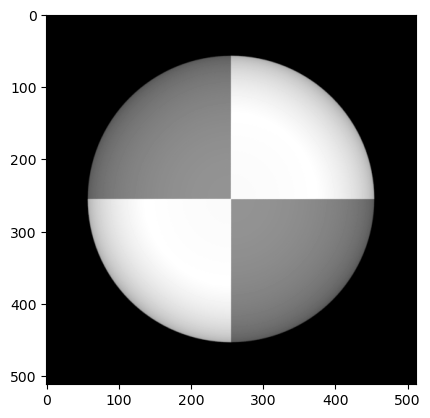

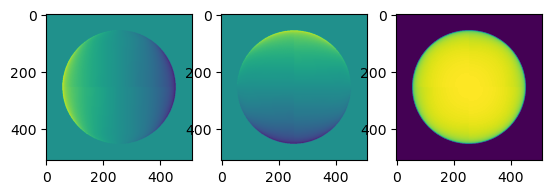

/tmp/ipykernel_10485/3244839544.py:163: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


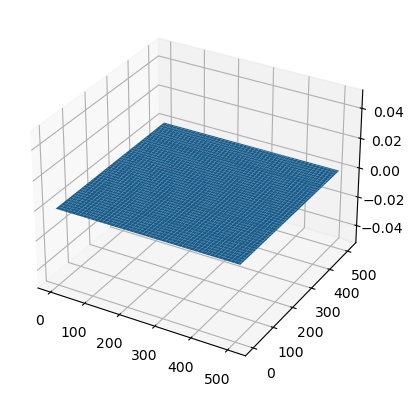

/tmp/ipykernel_10485/3244839544.py:170: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


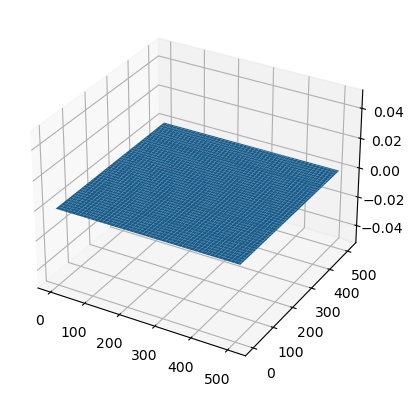

In [85]:
n = 5
image_stack, scriptV = load_syn_images(image_dir = './images/photometrics_images/SphereGray5/')
albedo, normal = estimate_alb_nrm( image_stack, scriptV, shadow_trick=True)
h, w = image_stack.shape[0], image_stack.shape[1]
SE = np.zeros(normal.shape[:2])
height_map = np.zeros([h, w])
show_results(albedo, normal, height_map, SE)

### 1.2 Test of Integrability (10pts)

Before we can reconstruct the surface height map, it is required to compute the partial derivatives $\frac{\delta f}{\delta x}$ and $\frac{\delta f}{\delta y}$ (or *p* and *q* in the algorithm). The partial derivatives also give us a chance to double check our computation, namely the test of *integrability*.

1. Compute the partial derivatives (p and q in the algorithm) by filling in your code into **check_integrability()**.

In [4]:
def check_integrability(normals):
    #  CHECK_INTEGRABILITY check the surface gradient is acceptable
    #   normals: normal image
    #   p : df / dx
    #   q : df / dy
    #   SE : Squared Errors of the 2 second derivatives

    # initalization
    p = np.zeros(normals.shape[:2])
    q = np.zeros(normals.shape[:2])
    SE = np.zeros(normals.shape[:2])
    
    """
    ================
    Your code here
    ================
    Compute p and q, where
    p measures value of df / dx
    q measures value of df / dy
    
    """

    # change nan to 0
    p[p!=p] = 0
    q[q!=q] = 0
    
    """
    ================
    Your code here
    ================
    approximate second derivate by neighbor difference
    and compute the Squared Errors SE of the 2 second derivatives SE
    
    """

    return p, q, SE

# if __name__ == '__main__':
#     normals = np.zeros([10,10,3])
#     check_integrability(normals)

2. Implement and compute the second derivatives according to the algorithm and perform the test of integrability by choosing a reasonable threshold. What could be the reasons for the errors? How does the test perform with different number of images used in the reconstruction process in Question 1?

*Write your answer here*

### 1.3 Shape by Integration (10pts)
To reconstruct the surface height map, we need to continuously integrate the partial derivatives over a path. However, as we are working with discrete structures, you will be simply summing their values.

The algorithm in the chapter presents a way to do the integration in column-major order, that is you start at the top-left corner and integrate along the first column, then go towards right along each row. Yet, it is also noticed that it would be better to use many different paths and average so as to spread around the errors in the derivative estimates.

1. Construct the surface height map using column-major order as described in the algorithm, then implement row-major path integration. Your code should now go to **construct_surface()**.

**Note**: By default, Numpy used row-major operations. So if you are unrolling an image to linearize the operation, you will end up with a row-major representation. Numpy can be configured to be column-major. Otherwise, if you are using the double for-loops without an unrolling operation, then this concern doesn’t apply.

**Hint**: You could further inspect the shape of the objects and normal directions by using **matplotlib.pyplot.quiver** function. You will have to choose appropriate sub-sampling ratios for proper illustration. You code goes to the **show_results()** in the first code cell.

In [5]:
def construct_surface(p, q, path_type='column'):

    '''
    CONSTRUCT_SURFACE construct the surface function represented as height_map
       p : measures value of df / dx
       q : measures value of df / dy
       path_type: type of path to construct height_map, either 'column',
       'row', or 'average'
       height_map: the reconstructed surface
    '''
    
    h, w = p.shape
    height_map = np.zeros([h, w])
    
    if path_type=='column':
        """
        ================
        Your code here
        ================
        % top left corner of height_map is zero
        % for each pixel in the left column of height_map
        %   height_value = previous_height_value + corresponding_q_value
        
        % for each row
        %   for each element of the row except for leftmost
        %       height_value = previous_height_value + corresponding_p_value
        
        """
    elif path_type=='row':
        """
        ================
        Your code here
        ================
        """
    elif path_type=='average':
        """
        ================
        Your code here
        ================
        """
        
    return height_map

2. What are the differences in the results of the two paths?


*Write your answer here*

3. Now, take the average of the results. Do you see any improvement compared to when using only one path? Are the construction results different with different number of images being used?

*Write your answer here*

### 1.4 Experiments with different objects (15pts)
In this part, you will try to run the photometric stereo algorithm in various number of scenarios to see how well it can be generalized.

1. Run the algorithm and show the results for the MonkeyGray model. 

In [6]:
def photometric_stereo(image_dir='./SphereGray5/' ):

    # obtain many images in a fixed view under different illumination
    print('Loading images...\n')
    [image_stack, scriptV] = load_syn_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)

    # compute the surface gradient from the stack of imgs and light source mat
    print('Computing surface albedo and normal map...\n')
    [albedo, normals] = estimate_alb_nrm(image_stack, scriptV)


    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking\n')
    [p, q, SE] = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface( p, q )

    # show results
    show_results(albedo, normals, height_map, SE)

## Face
def photometric_stereo_face(image_dir='./yaleB02/'):
    [image_stack, scriptV] = load_face_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print('Computing surface albedo and normal map...\n')
    albedo, normals = estimate_alb_nrm(image_stack, scriptV)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking')
    p, q, SE = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface(p, q )

    # show results
    show_results(albedo, normals, height_map, SE)
    
## Apple
def photometric_stereo_apple(image_dir='./Apple_png/'):
    [image_stack, scriptV] = load_apple_images(image_dir)
    [h, w, n] = image_stack.shape
    print('Finish loading %d images.\n' % n)
    print('Computing surface albedo and normal map...\n')
    albedo, normals = estimate_alb_nrm(image_stack, scriptV)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking')
    p, q, SE = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface(p, q )

    # show results
    show_results(albedo, normals, height_map, SE)

    
# if __name__ == '__main__':
#     photometric_stereo()
#     photometric_stereo_face()
#     photometric_stereo_apple()


2. The albedo results of the monkey may comprise more albedo errors than in case of the sphere. Observe and describe the errors. What could be the reason for those errors? You may want to experiment with different number of images as you did in Question 1 to see the effects. 

*Write your answer here*

3. How do you think that could help solving these errors?

*Write your answer here*

So far, we have assumed that albedos are 1-channel grayscale images and that input images are also 1-channel. To work with 3-channel images, a simple solution is to split the input image into separate channels and treat them individually. Yet, that would generate a small problem while constructing the surface normal map if a pixel value in a channel is zero.

1. Update the implementation to work for 3-channel RGB inputs and test it with 2 models SphereColor and MonkeyColor. 
2. Explain your changes and show your results. 

*Write your answer here*

3. Observe the problem in the constructed surface normal map and height map, explain why a zero pixel could be a problem and propose a way to overcome that.

*Write your answer here*

Now, it's the time to try the algorithm on real-world datasets. For that purpose, we are going to use the [Yale Face Database](http://cvc.cs.yale.edu/cvc/projects/yalefaces/yalefaces.html)

1. Run the algorithm for the Yale Face images (included in the lab material). 
2. Observe and discuss the results for different integration paths. 

**Hint**: For proper computation of albedo and surface normal, you may want to suspend the shadow trick described in the text, and use the original formula:
$$i = Vg(x,y)$$

*Write your answer here*

3. Discuss how the images violate the assumptions of the shape-from-shading methods. Remember to include specific input images to illustrate your points. 


*Write your answer here*

4. How would the results improve when the problematic images are all removed? Try it out and show the results here.

*Write your answer here*

Finally, show your results on real-world 3-channel RGB inputs, contained in the "Apple" folder, taken from [this dataset](http://vision.ucsd.edu/~nalldrin/research/cvpr08/datasets/) from the University of California San Diego.

1. Observe and discuss the results for different integration paths.

## 2 Colour Spaces (20pts)

In this part of the assignment, you will study the different colour spaces for image representations and experiment how to convert a given RGB image to a specific colour space.

### 2.1 RGB Colour Model (3pts)

Why do we use RGB colour model as a basis of our digital cameras and photography? How does a standard digital camera capture the full RGB colour image?

### 2.2 Colour Space Conversion (10pts)

Create a function to convert an RGB image into the following colour spaces by using the template code you are provided at the ConvertColourSpace function and other sub-functions. Visualize the new image and its channels separately in the same figure. That is, for example, in the case of HSV colour space, you need to visualize the converted HSV image, and its Hue, Saturation and Value channels separately (4 images, 1 figure). Do not change the already given code.

__Opponent Colour Space__

$\begin{pmatrix}
O_1 \\
O_2 \\
O_3
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R-G}{\sqrt{2}} \\
\frac{R+G-2B}{\sqrt{6}} \\
\frac{R+G+B}{\sqrt{3}}
\end{pmatrix}$

__Normalized RGB (rgb) Colour Space__

$\begin{pmatrix}
r \\
g \\
b
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R}{R+G+B} \\
\frac{G}{R+G+B} \\
\frac{B}{R+G+B}
\end{pmatrix}$

__HSV Colour Space__

Convert the RGB image into HSV Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2HSV)*.

__YCbCr Colour Space__

Convert the RGB image into YCbCr Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2YCrCb)*. Note, you need to arrange the channels in $Y, C_b$ and $C_r$ order.

__Grayscale__

Convert the RGB image into grayscale by using 3 different methods mentioned in
https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/
In the end, check and report which method OpenCV uses for grayscale conversion, include it as well, and visualize all 4 in the same figure.




In [ ]:
def rgb2grays(input_image):
    # converts an RGB into grayscale by using 4 different methods

    # ligtness method

    # average method

    # luminosity method

    # built-in opencv function

    return new_image


def rgb2opponent(input_image):
    # converts an RGB image into opponent colour space

    return new_image


def rgb2normedrgb(input_image):
    # converts an RGB image into normalized rgb colour space

    return new_image


def getColourChannels(input_image):

    R = input_image[:, :, 0]
    G = input_image[:, :, 1]
    B = input_image[:, :, 2]

    return [R, G, B]

In [ ]:
def visualize(input_image):
    # Fill in this function. Remember to remove the pass command
    pass

In [ ]:
def ConvertColourSpace(input_image, colourspace):
    '''
    Converts an RGB image into a specified color space, visualizes the
    color channels and returns the image in its new color space.

    Colorspace options:
      opponent
      rgb -> for normalized RGB
      hsv
      ycbcr
      gray

    P.S: Do not forget the visualization part!
    '''

    # Convert the image into double precision for conversions
    input_image = input_image.astype(np.float32)

    if colourspace.lower() == 'opponent':
        # fill in the rgb2opponent function
        new_image = rgbConversions.rgb2opponent(input_image)

    elif colourspace.lower() == 'rgb':
        # fill in the rgb2opponent function
        new_image = rgbConversions.rgb2normedrgb(input_image)

    elif colourspace.lower() == 'hsv':
        # use built-in function from opencv
        pass

    elif colourspace.lower() == 'ycbcr':
        # use built-in function from opencv
        pass

    elif colourspace.lower() == 'gray':
        # fill in the rgb2opponent function
        new_image = rgbConversions.rgb2grays(input_image)

    else:
        print('Error: Unknown colorspace type [%s]...' % colourspace)
        new_image = input_image

    visualize(new_image)

    return new_image


#if __name__ == '__main__':
    ## Replace the image name with a valid image
    #img_path = 'test.png'
    ## Read with opencv
    #I = cv2.imread(img_path)
    ## Convert from BGR to RGB
    ## This is a shorthand.
    #I = I[:, :, ::-1]

    #out_img = ConvertColourSpace(I, 'opponent.png')


**2.1**
We use the RGB color model because it comprises the three primary additive colors, red, green and blue. With these three colors we can produce any color we want, including white, which occurs when all colors are mixed [Szeliski Book Fig. 2.8]. We use additive colors because the contrast they create with black screens works very well to produce digital images [1]. RGB is also convenient because it mimics the trichromatic nature of the human eye, which has different types of receptors called cones to sense red, green and blue [Lecture 2]. To capture a colored image, a standard digital camera is equipped with sensors that translate the wavelength of the photons to an RGB value. To achieve this, the sensors contain a Bayer Filter, which has the appearance of a checkboard with red, green and blue squares [Lecture 2].

[1] https://medium.com/nerd-for-tech/the-color-theory-why-do-computers-use-rgb-instead-of-ryb-205b75d6e783

**2.2**
...


### 2.3 Colour Space Properties (5pts)

Explain each of those 5 colour spaces and their properties. What are the benefits of using a different colour space other than RGB? Provide reasons for each of the above cases. You can include your observations from the visualizations.

*Write your answer here*

### 2.4 More on Colour Spaces (2pts)

Find one more colour space from the literature and simply explain its properties and give a use case.

*Write your answer here*

## 3 Intrinsic Image Decomposition (15pts)
Intrinsic image decomposition is the process of separating an image into its formation components, such as reflectance (albedo) and shading (illumination). <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) Then, under the assumption of body (diffuse) reflection, linear sensor response and narrow band filters, the decomposition of the observed image $I(\vec{x})$ at position $\vec{x}$ can be approximated as the element-wise product of its albedo $R(\vec{x})$ and shading $S(\vec{x})$ intrinsics:

$$I(\vec{x})=R(\vec{x}) \times S(\vec{x})$$

In this part of the assignment, you will experiment with intrinsic image components to perform one of the computational photography applications; material recolouring. For the experiments, we will use images from a synthetic intrinsic image dataset. <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)

<a name="cite_note-1"></a><small>1. [^](#cite_ref-1) H. G. Barrow and J. M. Tenenbaum. Recovering intrinsic scene characteristics from images. Computer Vision Systems, pages 3-26, 1978.</small>

<a name="cite_note-2"></a><small>2. [^](#cite_ref-1) http://www.cic.uab.cat/Datasets/synthetic_intrinsic_image_dataset/



1. What other components can an image be decomposed other than albedo and shading Give an example and explain your reasoning. *(4pts)*

Other components of an image can be shape and pose [Lecture 3 p.42]. For instance, in 3D reconstruction from images of different objects, to be able to recreate the object from its components, albedo and illumination is not sufficient. We also need information about the shape (vector field of surface normal of object) and pose (how the object is placed in the space) to synthesize the object.

2. If you check the literature, you will see that almost all the intrinsic image decomposition datasets are composed of synthetic images. What might be the reason for that? *(2pts)*

Because it is very easy to model light in a 3D environment with artificial objects and capture millions of images automatically. Also, it is possible to extract the ground-truth intrinsic components of the object through the computer modeling software. On the other hand, capturing those images in different lighting conditions in real life and extracting the ground-truth intrinsic components is a very tedious and time-consuming manual process [Intrinsic Images in the Wild, Sean Bell et al.]